In [28]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression

from datetime import datetime

from PPO import PPO
from PPO_MINI import PPO as PPO_MINI
from PPO_GAE import PPO as PPO_GAE

from rocket import Rocket
from tqdm.auto import tqdm

import math

### Utils

In [29]:
def compare_episode_rewards(ax, rewards1, rewards2, label1="Agent 1", label2="Agent 2"):
    """
    Compare two sets of episodic rewards over training.
    and plot a linear regression trend line for each agent.
    """
    sns.set()

    # Plot raw episode rewards
    x1 = np.arange(len(rewards1))
    x2 = np.arange(len(rewards2))

    ax.plot(x1, rewards1, label=label1)
    ax.plot(x2, rewards2, label=label2)

    if len(rewards1) >= 2:
        X1 = x1.reshape(-1, 1)
        y1 = np.array(rewards1).reshape(-1, 1)
        reg1 = LinearRegression().fit(X1, y1)
        x1_pred = np.linspace(0, len(rewards1) - 1, 100).reshape(-1, 1)
        y1_pred = reg1.predict(x1_pred)
        ax.plot(x1_pred, y1_pred, "--", label=f"{label1} trend")

    if len(rewards2) >= 2:
        X2 = x2.reshape(-1, 1)
        y2 = np.array(rewards2).reshape(-1, 1)
        reg2 = LinearRegression().fit(X2, y2)
        x2_pred = np.linspace(0, len(rewards2) - 1, 100).reshape(-1, 1)
        y2_pred = reg2.predict(x2_pred)
        ax.plot(x2_pred, y2_pred, "--", label=f"{label2} trend")

    ax.set_title("Comparison of Episode Rewards")
    ax.set_xlabel("Episode")
    ax.set_ylabel("Reward")
    ax.legend()


def compare_episode_lengths(ax, lengths1, lengths2, label1="Agent 1", label2="Agent 2"):
    """
    Compare two sets of episode lengths over training,
    and plot a linear regression trend line for each agent.
    """
    sns.set()

    x1 = np.arange(len(lengths1))
    x2 = np.arange(len(lengths2))

    ax.plot(x1, lengths1, label=label1)
    ax.plot(x2, lengths2, label=label2)

    if len(lengths1) >= 2:
        X1 = x1.reshape(-1, 1)
        y1 = np.array(lengths1).reshape(-1, 1)
        reg1 = LinearRegression().fit(X1, y1)
        x1_pred = np.linspace(0, len(lengths1) - 1, 100).reshape(-1, 1)
        y1_pred = reg1.predict(x1_pred)
        ax.plot(x1_pred, y1_pred, "--", label=f"{label1} trend")

    if len(lengths2) >= 2:
        X2 = x2.reshape(-1, 1)
        y2 = np.array(lengths2).reshape(-1, 1)
        reg2 = LinearRegression().fit(X2, y2)
        x2_pred = np.linspace(0, len(lengths2) - 1, 100).reshape(-1, 1)
        y2_pred = reg2.predict(x2_pred)
        ax.plot(x2_pred, y2_pred, "--", label=f"{label2} trend")

    ax.set_title("Comparison of Episode Lengths")
    ax.set_xlabel("Episode")
    ax.set_ylabel("Episode Length")
    ax.legend()


def compare_best_rewards(
    ax, best_reward_1, best_reward_2, label1="Agent 1", label2="Agent 2"
):
    """
    Compare two best (maximum) single-episode rewards from the training runs
    """
    sns.set()

    x_positions = np.array([0, 1])
    best_rewards = [best_reward_1, best_reward_2]
    labels = [label1, label2]

    ax.bar(x_positions, best_rewards, tick_label=labels)
    ax.set_title("Comparison of Best Episode Rewards")
    ax.set_ylabel("Best Reward")


def compare_convergence_timestep(
    ax, conv_timestep_1, conv_timestep_2, label1="Agent 1", label2="Agent 2"
):
    """
    Compare the timesteps at which each agent converged
    """
    sns.set()

    x_positions = np.array([0, 1])
    val1 = conv_timestep_1 if conv_timestep_1 is not None else 0
    val2 = conv_timestep_2 if conv_timestep_2 is not None else 0

    conv_values = [val1, val2]
    labels = [label1, label2]

    ax.bar(x_positions, conv_values, tick_label=labels)
    ax.set_title("Comparison of Convergence Timesteps")
    ax.set_ylabel("Timestep of Convergence")

In [30]:
def aggregate_plots(plot_functions, max_cols=3):
    """
    Given a list of plotting functions, creates one big figure with subplots
    and calls each plotting function on its own subplot.

    Parameters:
        plot_functions: A list of callables. Each callable must have a signature:
                        func(ax: matplotlib.axes.Axes, ...)
                        and handle all its own plotting on that Axes.
        max_cols: Maximum number of columns in the subplot grid.

    Returns:
        The aggregated matplotlib Figure.
    """
    sns.set()
    num_plots = len(plot_functions)
    num_cols = min(max_cols, num_plots)
    num_rows = math.ceil(num_plots / num_cols)

    fig, axs = plt.subplots(num_rows, num_cols, figsize=(5 * num_cols, 4 * num_rows))

    # If there's only one subplot, make sure axs is iterable.
    if num_plots == 1:
        axs = [axs]
    else:
        axs = axs.flatten()

    # Call each plotting function on its own Axes
    for i, plot_func in enumerate(plot_functions):
        plot_func(ax=axs[i])

    # Remove any unused axes
    for j in range(i + 1, len(axs)):
        fig.delaxes(axs[j])

    fig.tight_layout()
    return fig

### Environment

In [6]:
max_ep_len=1000
env_name="RocketLanding"
task="landing"
# Initialize Rocket environment
env = Rocket(max_steps=max_ep_len, task=task, rocket_type="starship")

### Training logic

In [7]:
def train(
    agent,
    env,
    env_name="RocketLanding",
    task="landing",
    max_training_timesteps=6_000_000,
    render=False,
    max_ep_len=1000,
    print_freq=None,
    log_freq=None,
    save_model_freq=100_000,
    update_timestep=None,
    random_seed=0,
    convergence_threshold=None,
):
    """
    Train an agent on the Rocket environment.
    Returns the list of `episode_rewards` for later offline plotting.
    """

    if print_freq is None:
        print_freq = max_ep_len * 10  # e.g. 10000
    if log_freq is None:
        log_freq = max_ep_len * 2  # e.g. 2000
    if update_timestep is None:
        update_timestep = max_ep_len * 4  # e.g. 4000

    # Setup logging directory
    log_dir = "PPO_logs"
    os.makedirs(log_dir, exist_ok=True)
    log_dir = os.path.join(log_dir, env_name)
    os.makedirs(log_dir, exist_ok=True)

    run_num = len(next(os.walk(log_dir))[2])  # counting files for naming
    log_f_name = os.path.join(log_dir, f"PPO_{env_name}_log_{run_num}.csv")
    print("Logging at :", log_f_name)

    # Setup checkpoint directory
    directory = "PPO_preTrained"
    os.makedirs(directory, exist_ok=True)
    directory = os.path.join(directory, env_name)
    os.makedirs(directory, exist_ok=True)

    checkpoint_path = os.path.join(
        directory, f"PPO_{env_name}_{random_seed}_{run_num}.pth"
    )
    print("Save checkpoint path :", checkpoint_path)

    # Track time
    start_time = datetime.now().replace(microsecond=0)
    print("Started training at (GMT) : ", start_time)

    # Open log file
    log_f = open(log_f_name, "w+")
    log_f.write("episode,timestep,reward\n")

    # tracking variables
    print_running_reward = 0.0
    print_running_episodes = 0
    log_running_reward = 0.0
    log_running_episodes = 0

    time_step = 0
    i_episode = 0

    # Storing metrics
    episode_rewards = []  # Episode-level reward
    episode_lengths = []  # How many steps each episode took

    best_reward = float("-inf")
    best_reward_episode = None
    best_reward_timestep = None

    # If we define a threshold for "convergence," we'll track when it was first reached
    convergence_timestep = None
    convergence_episode = None

    window_size = 10  # for smoothing the plot

    # Main training loop

    pbar = tqdm(total=max_training_timesteps, desc="Training Timesteps")

    while time_step <= max_training_timesteps:
        state = env.reset()
        current_ep_reward = 0.0

        for t in range(1, max_ep_len + 1):
            # Select action
            action = agent.select_action(state)
            state, reward, done, _ = env.step(action)

            # Log to PPO buffer
            agent.buffer.rewards.append(reward)
            agent.buffer.is_terminals.append(done)

            time_step += 1
            current_ep_reward += reward
            pbar.update(1)

            # Render if needed
            if render and i_episode % 50 == 0:
                env.render()

            # Update PPO
            if time_step % update_timestep == 0:
                agent.update()

            # Logging
            if time_step % log_freq == 0:
                if log_running_episodes > 0:
                    log_avg_reward = log_running_reward / log_running_episodes
                else:
                    log_avg_reward = 0
                log_f.write(
                    "{},{},{}\n".format(i_episode, time_step, round(log_avg_reward, 4))
                )
                log_running_reward, log_running_episodes = 0.0, 0

            # Print average reward
            if time_step % print_freq == 0:
                if print_running_episodes > 0:
                    print_avg_reward = print_running_reward / print_running_episodes
                else:
                    print_avg_reward = 0
                print(
                    f"Episode : {i_episode} \t\t"
                    f"Timestep : {time_step} \t\t"
                    f"Average Reward : {round(print_avg_reward, 2)}"
                )
                print_running_reward, print_running_episodes = 0.0, 0

            # Save model
            if time_step % save_model_freq == 0:
                agent.save(checkpoint_path)
                print("Model saved at timestep:", time_step)

            if done:
                break

        # End of episode
        i_episode += 1
        print_running_reward += current_ep_reward
        print_running_episodes += 1
        log_running_reward += current_ep_reward
        log_running_episodes += 1

        episode_rewards.append(current_ep_reward)
        episode_lengths.append(t)

        # Track best episode reward
        if current_ep_reward > best_reward:
            best_reward = current_ep_reward
            best_reward_episode = i_episode
            best_reward_timestep = time_step

        # Check if we reached a "convergence" threshold
        if (convergence_threshold is not None) and (convergence_timestep is None):
            # If we just exceeded the threshold for the first time:
            if current_ep_reward >= convergence_threshold:
                convergence_timestep = time_step
                convergence_episode = i_episode

    pbar.close()
    log_f.close()

    end_time = datetime.now().replace(microsecond=0)
    print("Finished training at : ", end_time)
    print("Total training time  : ", end_time - start_time)

    metrics = {
        "start_time": start_time,
        "end_time": end_time,
        "training_duration": end_time - start_time,
        "episode_rewards": episode_rewards,
        "episode_lengths": episode_lengths,
        "best_reward": best_reward,
        "best_reward_episode": best_reward_episode,
        "best_reward_timestep": best_reward_timestep,
        "convergence_threshold": convergence_threshold,
        "convergence_timestep": convergence_timestep,
        "convergence_episode": convergence_episode,
        "total_episodes": i_episode,
        "final_timestep": time_step,
    }

    return metrics

### Experiments

#### Comparison of PPO Agent vs PPO Agent with minibatch

In [8]:
# State and action dimensions
state_dim = env.state_dims
action_dim = env.action_dims

lr_actor = 0.0003
lr_critic = 0.001
K_epochs = 80
eps_clip = 0.2
gamma = 0.99
has_continuous_action_space = False

ppo_agent = PPO(
    state_dim,
    action_dim,
    lr_actor,
    lr_critic,
    gamma,
    K_epochs,
    eps_clip,
    has_continuous_action_space,
)

ppo_minibatch_agent = PPO_MINI(
    state_dim,
    action_dim,
    lr_actor,
    lr_critic,
    gamma,
    K_epochs,
    eps_clip,
    has_continuous_action_space,
    mini_batch_size=64,  # example
)

metrics_ppo = train(
    ppo_agent,
    env,
    env_name="RocketLanding",
    task="landing",
    max_training_timesteps=1e5,
    convergence_threshold=200,
)


metrics_ppo_mini = train(
    ppo_minibatch_agent,
    env,
    env_name="RocketLanding",
    task="landing",
    max_training_timesteps=1e5,
    convergence_threshold=200,
)

Logging at : PPO_logs/RocketLanding/PPO_RocketLanding_log_19.csv
Save checkpoint path : PPO_preTrained/RocketLanding/PPO_RocketLanding_0_19.pth
Started training at (GMT) :  2025-03-19 17:05:11


Training Timesteps:   0%|          | 0/100000.0 [00:00<?, ?it/s]

Episode : 48 		Timestep : 10000 		Average Reward : -264.63
Episode : 96 		Timestep : 20000 		Average Reward : -198.31
Episode : 144 		Timestep : 30000 		Average Reward : -280.33
Episode : 191 		Timestep : 40000 		Average Reward : -246.31
Episode : 240 		Timestep : 50000 		Average Reward : -246.75
Episode : 285 		Timestep : 60000 		Average Reward : -239.53
Episode : 333 		Timestep : 70000 		Average Reward : -178.56
Episode : 382 		Timestep : 80000 		Average Reward : -144.56
Episode : 430 		Timestep : 90000 		Average Reward : -152.15
Episode : 478 		Timestep : 100000 		Average Reward : -64.0
Model saved at timestep: 100000
Finished training at :  2025-03-19 17:07:13
Total training time  :  0:02:02
Logging at : PPO_logs/RocketLanding/PPO_RocketLanding_log_20.csv
Save checkpoint path : PPO_preTrained/RocketLanding/PPO_RocketLanding_0_20.pth
Started training at (GMT) :  2025-03-19 17:07:13


Training Timesteps:   0%|          | 0/100000.0 [00:00<?, ?it/s]

Episode : 48 		Timestep : 10000 		Average Reward : -355.36
Episode : 96 		Timestep : 20000 		Average Reward : -260.01
Episode : 144 		Timestep : 30000 		Average Reward : -184.89
Episode : 193 		Timestep : 40000 		Average Reward : -159.19
Episode : 240 		Timestep : 50000 		Average Reward : -105.74
Episode : 287 		Timestep : 60000 		Average Reward : -166.27
Episode : 336 		Timestep : 70000 		Average Reward : -110.79
Episode : 383 		Timestep : 80000 		Average Reward : -75.29
Episode : 433 		Timestep : 90000 		Average Reward : -94.88
Episode : 481 		Timestep : 100000 		Average Reward : -95.38
Model saved at timestep: 100000
Finished training at :  2025-03-19 17:17:44
Total training time  :  0:10:31


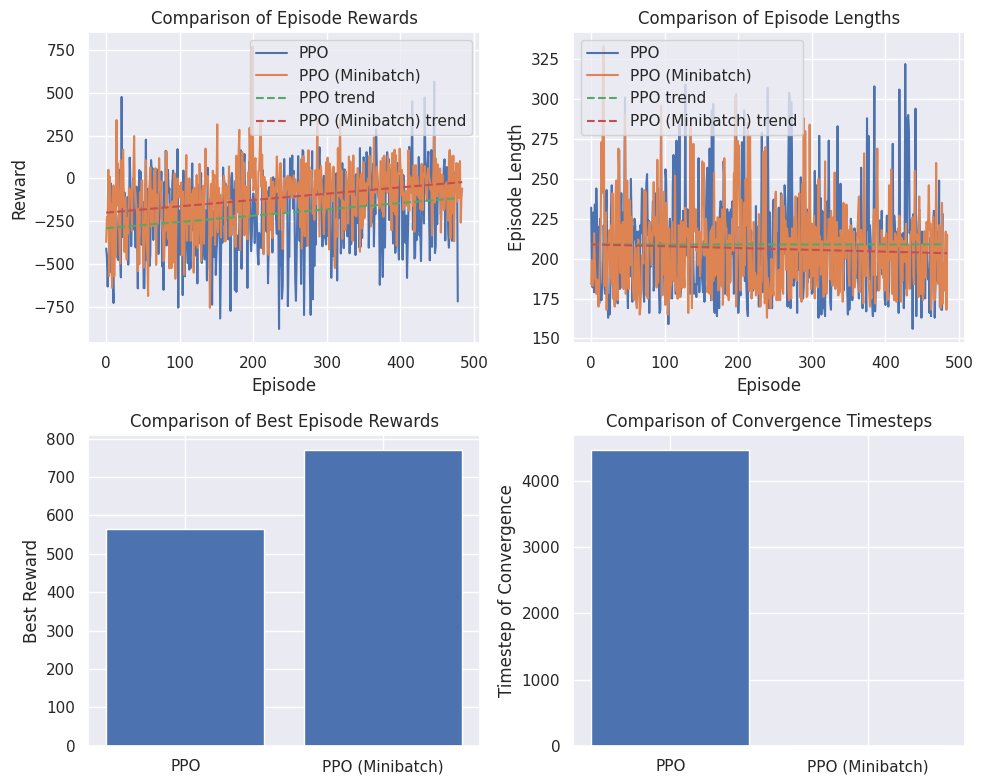

In [31]:
label1 = "PPO"
label2 = "PPO (Minibatch)"

plot_list = [
    lambda ax: compare_episode_rewards(
        ax,
        metrics_ppo["episode_rewards"],
        metrics_ppo_mini["episode_rewards"],
        label1,
        label2,
    ),
    lambda ax: compare_episode_lengths(
        ax,
        metrics_ppo["episode_lengths"],
        metrics_ppo_mini["episode_lengths"],
        label1,
        label2,
    ),
    lambda ax: compare_best_rewards(
        ax,
        metrics_ppo["best_reward"],
        metrics_ppo_mini["best_reward"],
        label1,
        label2,
    ),
    lambda ax: compare_convergence_timestep(
        ax,
        metrics_ppo["convergence_timestep"],
        metrics_ppo_mini["convergence_timestep"],
        label1,
        label2,
    ),
]
fig = aggregate_plots(plot_list, max_cols=2)

plt.show()

From the graph, we can see that using a mini batch improves the performance over the vanilla approach.

#### Comparison of PPO (MINIBATCH) with simple discounted return vs PPO (MINIBATCH) with GAE updates

Use Generalized Advantage Estimation (GAE-λ)

Current approach: Uses simple discounted return for each transition (Monte Carlo style).
New Approach: Switch to GAE for estimating advantages.
    GAE blends n-step returns with bias/variance tradeoff controlled by λ.
    This often significantly reduces variance compared to vanilla advantage estimates.
    Implementation steps:
        After collecting your rollout, compute delta δ
        Then compute advantage in reverse:
        Optionally normalize these advantages before each policy update.

In [ ]:
# State and action dimensions
state_dim = env.state_dims
action_dim = env.action_dims

lr_actor = 0.0003
lr_critic = 0.001
K_epochs = 80
eps_clip = 0.2
gamma = 0.99
has_continuous_action_space = False
mini_batch_size = 64
lam = 0.95


ppo_minibatch_agent = PPO_MINI(
    state_dim,
    action_dim,
    lr_actor,
    lr_critic,
    gamma,
    K_epochs,
    eps_clip,
    has_continuous_action_space,
    mini_batch_size=mini_batch_size,
)


ppo_gae_agent = PPO_GAE(
    state_dim,
    action_dim,
    lr_actor,
    lr_critic,
    gamma,
    K_epochs,
    eps_clip,
    has_continuous_action_space,
    mini_batch_size=mini_batch_size,
    lam=lam,
)

metrics_ppo_mini = train(
    ppo_minibatch_agent,
    env,
    env_name="RocketLanding",
    task="landing",
    max_training_timesteps=1e5,
    convergence_threshold=200,
)

metrics_ppo_gae = train(
    ppo_gae_agent,
    env,
    env_name="RocketLanding",
    task="landing",
    max_training_timesteps=1e5,
    convergence_threshold=200,
)

Logging at : PPO_logs/RocketLanding/PPO_RocketLanding_log_21.csv
Save checkpoint path : PPO_preTrained/RocketLanding/PPO_RocketLanding_0_21.pth
Started training at (GMT) :  2025-03-19 17:28:40


Training Timesteps:   0%|          | 0/100000.0 [00:00<?, ?it/s]

Episode : 47 		Timestep : 10000 		Average Reward : -191.45
Episode : 96 		Timestep : 20000 		Average Reward : -218.23
Episode : 144 		Timestep : 30000 		Average Reward : -174.82
Episode : 193 		Timestep : 40000 		Average Reward : -130.8
Episode : 239 		Timestep : 50000 		Average Reward : -45.12
Episode : 289 		Timestep : 60000 		Average Reward : -70.79
Episode : 337 		Timestep : 70000 		Average Reward : -97.32
Episode : 386 		Timestep : 80000 		Average Reward : -62.91
Episode : 435 		Timestep : 90000 		Average Reward : -56.26
Episode : 484 		Timestep : 100000 		Average Reward : -55.89
Model saved at timestep: 100000
Finished training at :  2025-03-19 17:39:30
Total training time  :  0:10:50
Logging at : PPO_logs/RocketLanding/PPO_RocketLanding_log_22.csv
Save checkpoint path : PPO_preTrained/RocketLanding/PPO_RocketLanding_0_22.pth
Started training at (GMT) :  2025-03-19 17:39:30


Training Timesteps:   0%|          | 0/100000.0 [00:00<?, ?it/s]

Episode : 47 		Timestep : 10000 		Average Reward : -157.93
Episode : 94 		Timestep : 20000 		Average Reward : -176.76
Episode : 144 		Timestep : 30000 		Average Reward : -166.32
Episode : 193 		Timestep : 40000 		Average Reward : -140.55
Episode : 238 		Timestep : 50000 		Average Reward : -132.38
Episode : 287 		Timestep : 60000 		Average Reward : -221.31
Episode : 336 		Timestep : 70000 		Average Reward : -412.02
Episode : 384 		Timestep : 80000 		Average Reward : -394.49
Episode : 434 		Timestep : 90000 		Average Reward : -661.36
Episode : 482 		Timestep : 100000 		Average Reward : -566.53
Model saved at timestep: 100000
Finished training at :  2025-03-19 17:41:47
Total training time  :  0:02:17


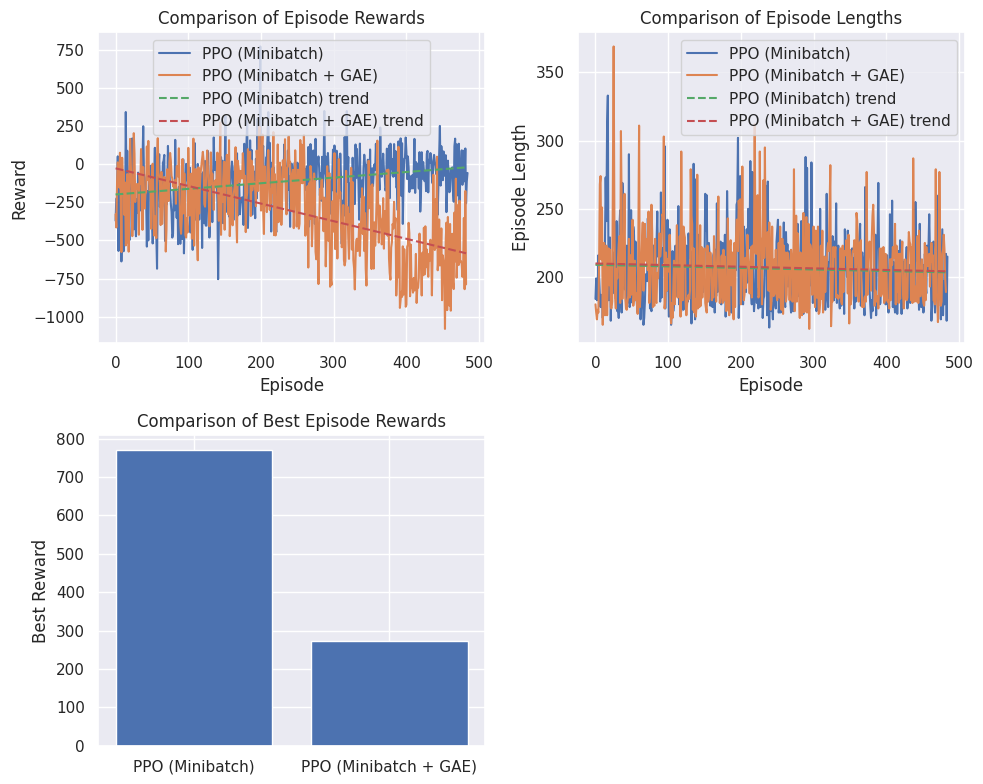

In [32]:
label1 = "PPO (Minibatch)"
label2 = "PPO (Minibatch + GAE)"

plot_list = [
    lambda ax: compare_episode_rewards(
        ax,
        metrics_ppo_mini["episode_rewards"],
        metrics_ppo_gae["episode_rewards"],
        label1,
        label2,
    ),
    lambda ax: compare_episode_lengths(
        ax,
        metrics_ppo_mini["episode_lengths"],
        metrics_ppo_gae["episode_lengths"],
        label1,
        label2,
    ),
    lambda ax: compare_best_rewards(
        ax,
        metrics_ppo_mini["best_reward"],
        metrics_ppo_gae["best_reward"],
        label1,
        label2,
    )
]
fig = aggregate_plots(plot_list, max_cols=2)
plt.show()